<a href="https://colab.research.google.com/github/Siddharth-Singh-2004/PyTorchFunctionality/blob/main/PyTorchFunctionalities.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [165]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt

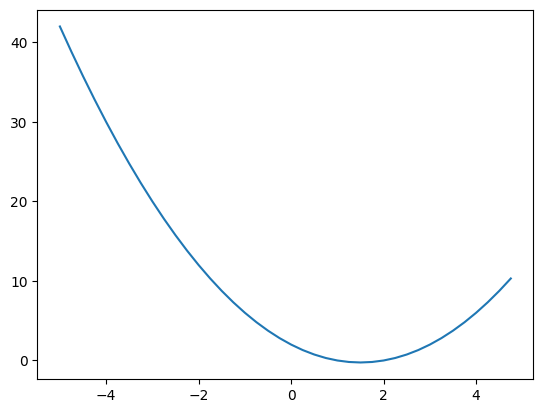

In [166]:
# Defining a function
def f(x):
  return x**2 - 3*x + 2

# Plotting the function
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [167]:
# Calculating gradient of the function
x = 3/2
h = 0.0001
(f(x+h) - f(x))/h

9.99999993922529e-05

Implementing with PyTorch

In [168]:
# Multi-variate functions
a = 3
b = 2
c = 7
d = a*(b**2) + c

h = 0.0001

# Calculating dd/db
b += h
d2 = a*(b**2) + c
(d2 - d)/h

12.000300000032382

In [169]:
class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward

    return out

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out

  def __rmul__(self, other):
    return self * other

  def __truediv__(self, other):
    return self * other**-1

  def __neg__(self):
    return self * -1

  def __sub__(self, other):
    return self + (-other)

  def __radd__(self, other):
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward

    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      self.grad += out.data * out.grad
    out._backward = _backward

    return out


  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()



In [170]:
import torch

In [171]:
x1 = torch.tensor([1.0]).double(); x1.requires_grad = True
w1 = torch.tensor([5.0]).double(); w1.requires_grad = True
x2 = torch.tensor([2.0]).double(); x2.requires_grad = True
w2 = torch.tensor([3.0]).double(); w2.requires_grad = True
b = torch.tensor([4.0]).double(); b.requires_grad = True

o = x1*w1 + x2*w2 + b
print(o.data)
o.backward()

print(x1.grad.data.item())
print(w1.grad.data.item())
print(x2.grad.data.item())
print(w2.grad.data.item())


tensor([15.], dtype=torch.float64)
5.0
1.0
3.0
2.0


In [172]:

class Neuron:

  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))

  def __call__(self, x):
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]

class Layer:

  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:

  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [173]:
x = [2.0, 3.0, 5.0]
n = MLP(3, [4, 5, 1])
n(x)

Value(data=-0.22595081601963954)

In [174]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

In [179]:
epochs = 100

for k in range(epochs):

  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad

  print(f"epoch {k}, loss: {loss.data}")


epoch 0, loss: 0.006175328946344426
epoch 1, loss: 0.006041538155021595
epoch 2, loss: 0.005913302904185328
epoch 3, loss: 0.005790285559357542
epoch 4, loss: 0.005672175379516906
epoch 5, loss: 0.00555868587335661
epoch 6, loss: 0.005449552464384203
epoch 7, loss: 0.005344530423096415
epoch 8, loss: 0.005243393030874306
epoch 9, loss: 0.005145929945556528
epoch 10, loss: 0.005051945743069227
epoch 11, loss: 0.004961258613183016
epoch 12, loss: 0.004873699190566488
epoch 13, loss: 0.004789109504914641
epoch 14, loss: 0.004707342036134915
epoch 15, loss: 0.004628258862444851
epoch 16, loss: 0.004551730890826826
epoch 17, loss: 0.00447763716064307
epoch 18, loss: 0.0044058642123791705
epoch 19, loss: 0.0043363055144815775
epoch 20, loss: 0.0042688609421165785
epoch 21, loss: 0.004203436302420266
epoch 22, loss: 0.004139942901452252
epoch 23, loss: 0.004078297148624287
epoch 24, loss: 0.004018420194860372
epoch 25, loss: 0.003960237601168301
epoch 26, loss: 0.0039036790346723294
epoch 27,

In [180]:
ypred

[Value(data=0.9888606863075148),
 Value(data=-0.9711082407397805),
 Value(data=-0.9791418231109739),
 Value(data=0.9776437434727583)]